In [0]:
import importlib
import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as spc

%matplotlib inline
importlib.reload(psychrnn)


def weight_concat(model):
    weights = model.get_weights()
    inputw = np.concatenate([weights['W_in'],weights['W_rec']],axis = 1)
    outputw = np.concatenate([weights['W_rec'].T,weights['W_out'].T],axis = 1)
    allw = np.concatenate([inputw,outputw],axis = 1)
    return inputw, outputw, allw
def weight_sort_plot(W):
    this_W = W
    corr = np.corrcoef(this_W)
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
    corr_sort = np.corrcoef(this_W[corr_idx])
    max_idx = np.argsort(np.argmax(this_W,axis = 1))
    f,ax = plt.subplots(1,4,figsize = (16,4))
    ax[0].imshow(corr_sort,aspect = 'auto')
    ax[1].imshow(this_W,aspect = 'auto')
    ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
    ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
     
# from brian2 import *

In [0]:
dt = 1 # time-step
tau = 10 # intrinsic time constant of neural state decay
T = 100 # time to run for (number of steps is T/dt)
N_batch = 10 # number of trials per training step
N_rec = 40 # number of recurrent units
name = 'basicModel'
N_in = 2
N_out = 1

In [0]:
from psychrnn.tasks.task import Task

class nxor(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(nxor,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = params['inputs'][0] != params['inputs'][1]
        params['neuron_noise'] = 0.01
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t += params['inputs'] + np.random.randn(self.N_in) * params['neuron_noise']
            
        if   t>(params['onset']+params['delay']):
            y_t += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t
    
class autoencode_plus_nxor(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(autoencode_plus_nxor,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = params['inputs'][0] != params['inputs'][1]
        params['input_noise'] = 0.5
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t += params['inputs'] + np.random.randn(self.N_in) * params['input_noise']
            
        if   t>(params['onset']+params['delay']):
            y_t[:2] += params['inputs']
            y_t[2] += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t
    
    
class nxor_onehot(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(nxor_onehot,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = np.zeros(self.N_out)
        params['outputs'][0] = params['inputs'][0] != params['inputs'][1]
        params['outputs'][1] = int(not params['outputs'][0])
        params['neuron_noise'] = 0.01
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t += params['inputs'] + np.random.randn(self.N_in) * params['neuron_noise']
            
        if   t>(params['onset']+params['delay']):
            y_t += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t
    
    
class nxor_onehot_cue(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(nxor_onehot_cue,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = np.zeros(self.N_out)
        params['outputs'][0] = params['inputs'][0] != params['inputs'][1]
        params['outputs'][1] = int(not params['outputs'][0])
        params['neuron_noise'] = 0.01
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t[:2] += params['inputs'] + np.random.randn(2) * params['neuron_noise']
            
        if   (t>params['onset']) and (t<(params['onset']+params['delay'] )): 
            x_t[2] = 1
            
        if   t>(params['onset']+params['delay']):
            y_t += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t    
    
class gain_mod(Task):
    
    def __init__(self,N_in, N_out, dt, tau, T, N_batch):
        super(gain_mod,self).__init__(2, 2, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6
        params['duration'] = 500
        params['delay'] = 10
        params['inputs'] = np.random.binomial(1,0.5,size = 2)
        params['outputs'] = np.zeros(self.N_out)
        params['outputs'][0] = params['inputs'][0] != params['inputs'][1]
        params['outputs'][1] = int(not params['outputs'][0])
        params['neuron_noise'] = 0.01
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) 
        y_t = np.zeros(self.N_out) 
         

        
        if (t>params['onset']):
            x_t[:2] += params['inputs'] + np.random.randn(2) * params['neuron_noise']
            
        if   (t>params['onset']) and (t<(params['onset']+params['delay'] )): 
            x_t[2] = 1
            
        if   t>(params['onset']+params['delay']):
            y_t += params['outputs'] 

        mask_t = np.ones(self.N_out)
        
        return x_t, y_t, mask_t    
    


In [0]:
# swv = nxor(N_in = 2, N_out = 1, dt = dt, tau = tau, T = T, N_batch = N_batch)
# swv = nxor_onehot(N_in = 2, N_out = 2, dt = dt, tau = tau, T = T, N_batch = N_batch)
swv = nxor_onehot_cue(N_in = 3, N_out = 2, dt = dt, tau = tau, T = T, N_batch = N_batch)
# swv = autoencode_plus_nxor(N_in = 2, N_out = 3, dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()
tgen = swv.batch_generator_with_params()
params = swv.__dict__
print(params)

{'N_batch': 10, 'N_in': 3, 'N_out': 2, 'dt': 1, 'tau': 10, 'T': 100, 'alpha': 0.1, 'N_steps': 100}


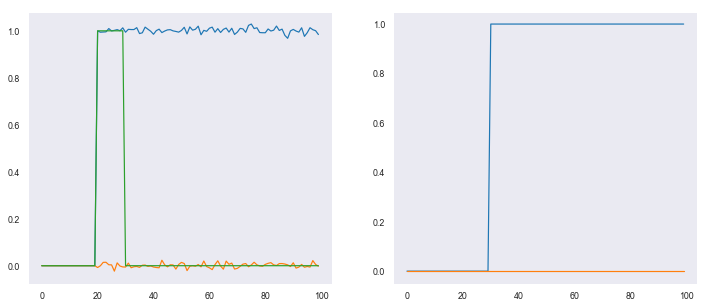

In [0]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(x[0,:,:])
ax[1].plot(y[0,:,:])

In [0]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec
params['dale_ratio'] = 0.6 # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.00 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None

params['L2_out'] = 0
params['L2_rec'] = 0
params['L2_in'] = 0
params['L2_firing_rate_reg'] = 0

params['L1_firing_rate_reg'] = 0
params['L1_out'] = 0
params['L1_in'] = 0
params['L1_rec'] = 0

In [0]:
basicModel.destruct()

In [0]:
basicModel = Basic(params)
basicModel.build()
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 15000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 15000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x1a8bfed2d68>,
 'clip_grads': True}

In [0]:
basicModel.train(gen, train_params)

Iter 100, Minibatch Loss= 0.168056
Iter 200, Minibatch Loss= 0.161176
Iter 300, Minibatch Loss= 0.189210
Iter 400, Minibatch Loss= 0.165865
Iter 500, Minibatch Loss= 0.165696
Iter 600, Minibatch Loss= 0.168799
Iter 700, Minibatch Loss= 0.157334
Iter 800, Minibatch Loss= 0.138640
Iter 900, Minibatch Loss= 0.149686
Iter 1000, Minibatch Loss= 0.121359
Training weights saved in file: None100
Iter 1100, Minibatch Loss= 0.148016
Iter 1200, Minibatch Loss= 0.148568
Iter 1300, Minibatch Loss= 0.163139
Iter 1400, Minibatch Loss= 0.149995
Iter 1500, Minibatch Loss= 0.148173
Iter 1600, Minibatch Loss= 0.138990
Iter 1700, Minibatch Loss= 0.115372
Iter 1800, Minibatch Loss= 0.156848
Iter 1900, Minibatch Loss= 0.143800
Iter 2000, Minibatch Loss= 0.115592
Training weights saved in file: None200
Iter 2100, Minibatch Loss= 0.160467
Iter 2200, Minibatch Loss= 0.135822
Iter 2300, Minibatch Loss= 0.150008
Iter 2400, Minibatch Loss= 0.158388
Iter 2500, Minibatch Loss= 0.156283
Iter 2600, Minibatch Loss= 0.

([0.16805619,
  0.16117603,
  0.18920967,
  0.16586505,
  0.16569561,
  0.16879936,
  0.15733352,
  0.1386398,
  0.14968608,
  0.12135948,
  0.14801642,
  0.14856814,
  0.16313876,
  0.14999504,
  0.14817277,
  0.13899027,
  0.115371875,
  0.1568478,
  0.14380014,
  0.115592375,
  0.16046742,
  0.13582171,
  0.1500079,
  0.15838827,
  0.15628329,
  0.1544836,
  0.13507996,
  0.15663485,
  0.1553527,
  0.14945938,
  0.14730847,
  0.13440563,
  0.153343,
  0.15005179,
  0.1514798,
  0.16666695,
  0.16291727,
  0.17220718,
  0.14690346,
  0.120525956,
  0.15082052,
  0.14714079,
  0.13773532,
  0.14504491,
  0.1499239,
  0.14799334,
  0.16495124,
  0.17255323,
  0.1593656,
  0.14473031,
  0.1389647,
  0.15486765,
  0.1493182,
  0.14662448,
  0.1418755,
  0.13410996,
  0.1433157,
  0.13310964,
  0.13518229,
  0.09993172,
  0.1309663,
  0.09857283,
  0.113924034,
  0.13006836,
  0.09797391,
  0.064450815,
  0.09166321,
  0.08309703,
  0.09729542,
  0.087020144,
  0.089511305,
  0.08614303,


In [0]:
x,y,m,p = next(tgen)
results = basicModel.test(x)
output = results[0]
state_var = results[1]

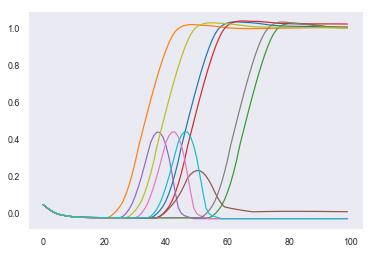

In [0]:
output0 = output[:,:,0].copy()
plt.plot(output0.T);

In [0]:
p_inputs = np.stack([tp['inputs'] for tp in p])
p_outputs = np.stack([tp['outputs'] for tp in p])
p_io = np.concatenate([p_inputs,p_outputs],axis = 1).astype(int)

In [0]:
df = pd.DataFrame(p_io)
df.columns = ['i0_trial','i1_trial','o0_trial','o1_trial']
df

,i1_trial,i2_trial,o1_trial,o2_trial
0,1,0,1,0
1,1,1,0,1
2,1,1,0,1
3,0,0,0,1
4,0,1,1,0
5,0,0,0,1
6,0,0,0,1
7,1,1,0,1
8,0,1,1,0
9,0,1,1,0


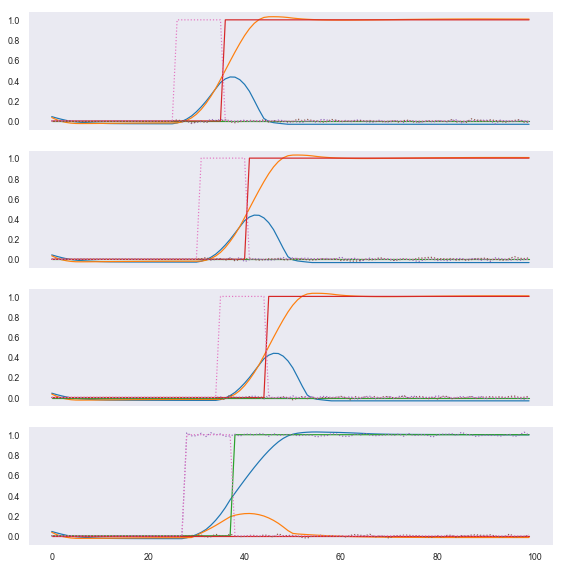

In [0]:
sns.set_style('dark')
sns.set_context('paper')
num_plots = 4
toshow = np.random.choice(output.shape[0],5,replace = False)
f,axes = plt.subplots(4,1,figsize = (8,8),sharey = True,sharex = True)
axes.flatten()
for i,ax in zip(toshow,axes):
    ax.plot(range(0, len(output[i,:,:])*dt,dt),output[i,:,:])
#     ax.set_title(i)
    ax.plot(range(0, len(y[i,:,:])*dt,dt), y[i,:,:])
    ax.plot(range(0, len(x[i,:,:])*dt,dt), x[i,:,:],':')
plt.tight_layout()

In [0]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0
inputw, outputw, allw = weight_concat(basicModel)

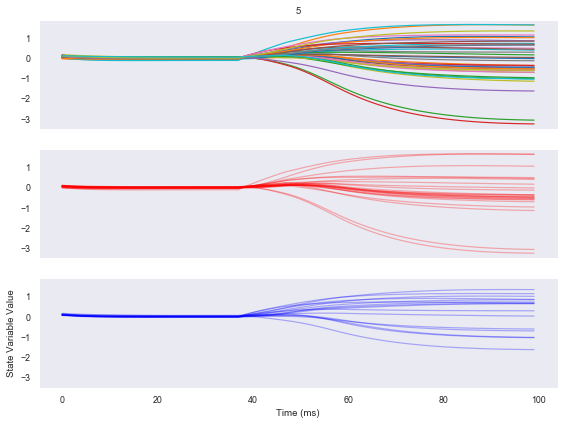

In [0]:
f,ax = plt.subplots(3,1,figsize = (8,6),sharex = True, sharey = True)

i = np.random.choice(output.shape[0])
ax[0].plot(range(0, len(state_var[i,:,:])*dt,dt),state_var[i,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
ax[0].set_title(i)

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

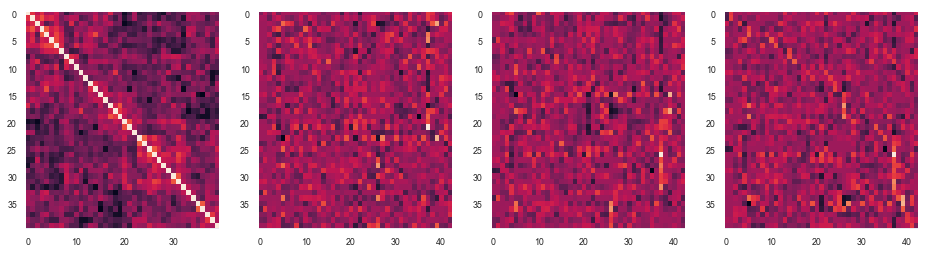

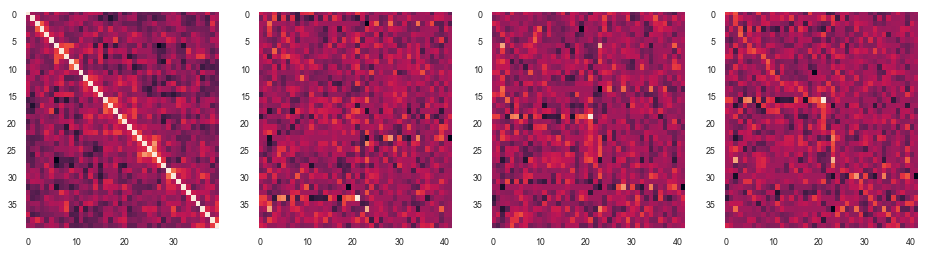

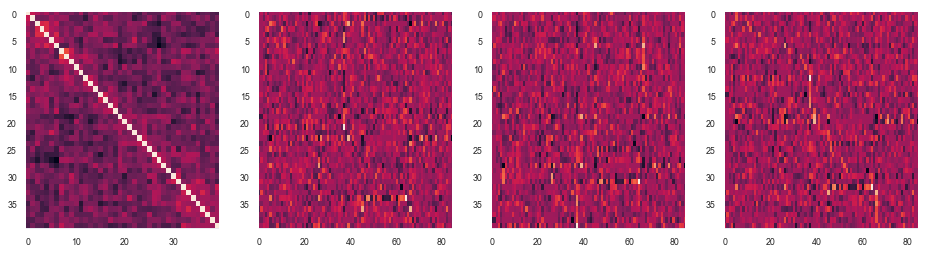

In [0]:
weight_sort_plot(inputw)
weight_sort_plot(outputw)
weight_sort_plot(allw)

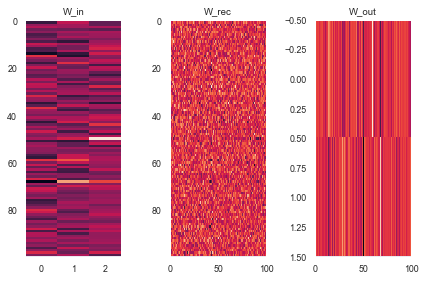

In [0]:
f,ax = plt.subplots(1,3)
for axi,key in  enumerate(['W_in', 'W_rec', 'W_out']):
    ax[axi].imshow(weights[key],aspect = 'auto')
    ax[axi].set_title(key)
plt.tight_layout()

In [0]:
weight_sort_plot(weights['W_in'][E,:])
weight_sort_plot(weights['W_rec'][E,:])
weight_sort_plot(weights['W_out'][:,E].T)

In [0]:
# this_W = weights['W_in'][E,:]
this_W = weights['W_out'][:,E].T
# this_W = weights['W_rec'][E,:]
corr = np.corrcoef(this_W)
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
corr_sort = np.corrcoef(this_W[corr_idx])
max_idx = np.argsort(np.argmax(this_W,axis = 1))
f,ax = plt.subplots(1,4,figsize = (16,4))
ax[0].imshow(corr_sort,aspect = 'auto')
ax[1].imshow(this_W,aspect = 'auto')
ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
this_idx = corr_idx


In [0]:
f,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(weights['W_in'][this_idx,:],aspect = 'auto')
ax[1].imshow(weights['W_rec'][this_idx,:],aspect = 'auto')
ax[2].imshow(weights['W_out'][:,this_idx].T,aspect = 'auto')

In [0]:
weights['W_out'].shape

In [0]:
import seaborn as sns
sns.distplot(allw.flatten())

In [0]:
weight_sort_plot(allw[E,:])

In [0]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [0]:
dale_rec

Clean up the model to clear out the tensorflow namespace

In [0]:
basicModel.destruct()

In [0]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)